In [11]:
from process_edus import EDUSample

In [12]:
data = EDUSample()
path = r'../LabeledEDUS_final.txt'

edus, targets = data.read_labeled(path)


=====> DATA LOADED


In [13]:
import tensorflow as tf

In [14]:
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D, LSTM, TimeDistributed

In [15]:
GLOVE_PATH = r'../../../GloVe/glove.6B.100d.txt'

In [16]:
# tokenize edus
t = Tokenizer()
t.fit_on_texts(edus)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_edus = t.texts_to_sequences(edus)

# max_length = 1 << (max(map(lambda x: len(x), encoded_edus)) - 1).bit_length()  # pad to smallest power of 2 greater than the largest edu
max_length = sum(map(lambda x: len(x), encoded_edus)) // len(encoded_edus)       # pad to the average length of edus
padded_edus = pad_sequences(encoded_edus, maxlen=max_length)

In [17]:
X_train, y_train, X_test, y_test = data.split_data(padded_edus, targets)

In [18]:
print('Preparing embedding matrix.')
# load the whole embedding into memory
embeddings_index = dict()
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.
Loaded 400000 word vectors.


In [56]:
# Using regularization 
regularizer = None
regularization = True
dropout = True
if regularization:
    regularizer = l1(0.0001)

In [57]:
print('Model Setup') 

inputs = Input(shape=(max_length,), dtype='int32')
embed_sequence = Embedding(vocab_size, 100, 
                           #weights=[embedding_matrix],
                           embeddings_initializer=Constant(embedding_matrix), 
                           input_length=max_length,
                           trainable=False)(inputs)

x = LSTM(32, return_sequences=False, kernel_regularizer=regularizer)(embed_sequence)

if dropout:
    x = Dropout(0.25)(x)

preds = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=regularizer)(x)

model = Model(inputs, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print('Fitting model')
model.fit(X_train, y_train, 
          epochs=5,
          batch_size=1
         )


Model Setup
Fitting model
Epoch 1/5
2266/2266 [==============================] - 28s 12ms/step - loss: 0.6229 - acc: 0.7184
Epoch 2/5
2266/2266 [==============================] - 24s 11ms/step - loss: 0.5012 - acc: 0.8094
Epoch 3/5
2266/2266 [==============================] - 29s 13ms/step - loss: 0.4652 - acc: 0.8222
Epoch 4/5
2266/2266 [==============================] - 30s 13ms/step - loss: 0.4372 - acc: 0.8451
Epoch 5/5
2266/2266 [==============================] - 28s 12ms/step - loss: 0.4096 - acc: 0.8544


In [58]:
results = model.predict(X_test)
results = np.array([0 if r < 0.5 else 1 for r in results])

In [59]:
# m = model.evaluate(X_test, y_test)
model.evaluate(X_test, y_test), model.evaluate(X_train, y_train)

2266/2266 [==============================] - 0s 89us/step


([0.5164633674739424, 0.79523389258431],
 [0.36981119103696847, 0.8693733448910692])

In [25]:
accuracy_score(y_test, results)

0.799771167048055

In [26]:
precision_recall_fscore_support(y_test, results, average='macro')

(0.7993257155431213, 0.8, 0.7994853084806113, None)

In [44]:
# list(zip(model.predict(X_train), y_train))

Using TensorFlow backend.


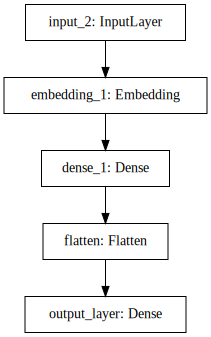

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))